# Partie 2 : évolution des caractéristiques selon la suppression

## Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist

import random

from swarm_sim import *



%matplotlib inline

## Reprise des graphes d'origine

In [2]:
PATH = 'Traces.csv'

df = pd.read_csv(PATH, sep=',', header=None)
satellites = {}

for i in range(0,100):
    sat = df.iloc[3*i : 3*i+3].copy()
    sat['coords'] = ['x','y','z']
    satellites[i] = sat.set_index('coords', drop=True)

RANGE1 = 20000
RANGE2 = 40000
RANGE3 = 60000

list_satellites = []

for i in range(len(satellites)):
    obj_sat = Node.__new__(Node)
    obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])
    list_satellites.append(obj_sat)

swarm = Swarm.__new__(Swarm)
swarm.__init__(RANGE1, list_satellites)
graph1 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE2, list_satellites)
graph2 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE3, list_satellites)
graph3 = swarm.swarm_to_nxgraph()

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

def afficher_graphe_avec_layout(graph):
    pos = nx.spring_layout(graph)
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")
    nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

/tmp/ipykernel_220850/1885389153.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])


## Fonctions d'affichage des données pour comparer avant et après suppression des satellites

In [3]:
def path_redundancy(G):
    nodes = list(G.nodes)
    total = 0
    count = 0
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            try:
                paths = list(nx.all_shortest_paths(G, source=nodes[i], target=nodes[j]))
                total += len(paths)
                count += 1
            except nx.NetworkXNoPath:
                continue
    return total / count if count > 0 else 0

In [5]:
def path_disparity(G):
    nodes = list(G.nodes)
    disparities = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            try:
                paths = list(nx.all_shortest_paths(G, nodes[i], nodes[j]))
                if len(paths) < 2:
                    continue
                d_uv = nx.shortest_path_length(G, nodes[i], nodes[j])
                total_diff = 0
                for p1 in paths:
                    for p2 in paths:
                        if p1 == p2: continue
                        sym_diff = len(set(p1) ^ set(p2))
                        total_diff += sym_diff / (d_uv - 1)
                disparities.append(total_diff / (len(paths)**2 - len(paths)))
            except:
                continue
    return np.mean(disparities) if disparities else 0


In [6]:
def critical_nodes(G, epsilon=0.05):
    centralities = nx.betweenness_centrality(G, normalized=True)
    return [n for n, v in centralities.items() if v >= epsilon]

In [7]:
#Prend en paramètre les graphes après suppression pour les comparer aux anciens graphes
def comparaison_graphs(graph_apres1, graph_apres2, graph_apres3):
    graphes = [
        (graph1, graph_apres1),
        (graph2, graph_apres2),
        (graph3, graph_apres3)
    ]

    noms = ['Graphe <20km', 'Graphe <40km', 'Graphe <60km']

    # Listes pour stocker les résultats (plusieurs pour que ce soit lisible sur une ligne)
    donnees_tab1 = []
    donnees_tab2 = []
    donnees_tab3 = []

    # Boucle sur les graphes
    for i in range(len(noms)):
        g_before, g_after = graphes[i]
        
        nb_arcs = g_before.number_of_edges()
        nb_arcs_after = g_after.number_of_edges()
        nb_noeuds = g_before.number_of_nodes()
        nb_noeuds_after = g_after.number_of_nodes()
        degre_moyen = np.mean([d for _, d in g_before.degree()])
        degre_moyen_after = np.mean([d for _, d in g_after.degree()])
        graphe_connecte = nx.is_connected(g_before)
        graphe_connecte_apres = nx.is_connected(g_after)
        nb_communaute = len(nx.community.label_propagation_communities(g_before))
        nb_communaute_apres = len(nx.community.label_propagation_communities(g_after))
        coeff_clustering = nx.average_clustering(g_before)
        coeff_clustering_apres = nx.average_clustering(g_after)
        redundancy = path_redundancy(g_before)
        redundancy_after = path_redundancy(g_after)
        #ne pas hésiter à commenter les deux lignes suivantes pour réduire le temps d'exécution
        #penser à commenter également les lignes dans donnees_tab2
        disparite = path_disparity(g_before), 
        disparite_apres = path_disparity(g_after)
        criticite = critical_nodes(g_before)
        criticite_after = critical_nodes(g_after)


        donnees_tab1.append({
            "Nom": noms[i],
            "Nombre d'arcs": nb_arcs,
            "Nombre d'arcs après suppression": nb_arcs_after,
            "Nombre de noeuds": nb_noeuds,
            "Nombre de noeuds après suppression": nb_noeuds_after,
            "Degré moyen des noeuds": degre_moyen,
            "Degré moyen des noeuds après suppression": degre_moyen_after,
            "Graphe connecté ?": graphe_connecte,
            "Graphe connecté après ?"  : graphe_connecte_apres
        })

        donnees_tab2.append({
            "Nom": noms[i],
            "Nombre de communautés": nb_communaute,
            "Nombre de communautés après": nb_communaute_apres,
            "Coefficient de clustering": coeff_clustering,
            "Coefficient de clustering après": coeff_clustering_apres,
            "Redondance": redundancy,
            "Redondance après": redundancy_after,
            "Disparité": disparite,
            "Disparité après": disparite_apres,
            "Criticité": criticite,
            "Criticité après": criticite_after
        })

    #remplissage deuxieme tableau seulement avec le graphe3 qui est le seul connecté
    g_before, g_after = graphes[2]
    if nx.is_connected(g_before):
        shortest_paths_mean = nx.average_shortest_path_length(g_before)
        diameter = nx.diameter(g_before)
    else:
        shortest_paths_mean = "∞"
        diameter = "∞"

    if nx.is_connected(g_after):
        shortest_paths_mean_apres = nx.average_shortest_path_length(g_after)
        diameter_after = nx.diameter(g_after)
    else:
        shortest_paths_mean_apres = "∞"
        diameter_after = "∞"

    donnees_tab3.append({
        "Nom": noms[2],
        "Moyenne des plus courts chemins": shortest_paths_mean,
        "Moyenne des plus courts chemins après": shortest_paths_mean_apres,
        "Diamètre": diameter,
        "Diamètre après": diameter_after,
    })

    display(pd.DataFrame(donnees_tab1))
    display(pd.DataFrame(donnees_tab2))
    display(pd.DataFrame(donnees_tab3))



# Fonction de suppression des noeuds

In [13]:
def delete_nodes(graph, nodes):
    """
    Supprime une liste de nœuds d'un graphe.

    Paramètres :
        - graph : le graphe à modifier
        - nodes : liste des nœuds à supprimer

    Retour :
        - Graphe modifié
    """
    graph.remove_nodes_from(nodes)
    return graph

## Suppression aléatoire de satellites

In [14]:
def list_nodes_random(graph, n, seed=None):
    import random
    random.seed(seed)
    return random.sample(list(graph.nodes), n)


In [15]:
def generate_randomly_reduced_graph(graph, n, seed=None):
    nodes = list_nodes_random(graph, n, seed)
    return delete_nodes(graph.copy(), nodes)


In [16]:
graph1r = generate_randomly_reduced_graph(graph1, 20, seed=42)
graph2r = generate_randomly_reduced_graph(graph2, 20, seed=42)
graph3r = generate_randomly_reduced_graph(graph3, 20, seed=42)

comparaison_graphs(graph1r, graph2r, graph3r)


,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,107,100,80,3.48,2.675,False,False
1,Graphe <40km,883,597,100,80,17.66,14.925,False,False
2,Graphe <60km,1958,1282,100,80,39.16,32.050,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,30,0.345716,0.286667,3.607920,2.918539,"(0.8615447679255358,)",0.852905,"[6, 7, 22, 39, 68, 70]","[6, 22, 68, 70]"
1,Graphe <40km,6,5,0.633008,0.634800,29.926824,21.525794,"(1.6755923707745828,)",1.605678,"[22, 97]","[22, 40, 48, 58, 70, 97]"
2,Graphe <60km,1,1,0.750514,0.766571,43.953131,25.796835,"(1.8480840346015286,)",1.861825,[],[]


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,1.825633,7,5


In [8]:

def analyse_graph_on_graphobj_df(graph, nb_to_remove, seed=None, targeted=False, centrality=False, display=True):
    """
    Analyse graphique avec retour sous forme de DataFrame des métriques réseau avant/après suppression sur un graphe donné.

    Paramètres :
        - graph : objet NetworkX existant (graph1, graph2 ou graph3)
        - nb_to_remove : nombre de satellites à supprimer
        - seed : graine pour reproductibilité
        - targeted : True pour supprimer les plus connectés
        - centrality : True pour supprimer les plus centraux
        - display : affiche les graphes avant/après

    Retour :
        - DataFrame avec les métriques avant/après et la liste des satellites supprimés
    """
    random.seed(seed)
    graph_full = graph.copy()

    # Sélection des nœuds à supprimer
    if targeted:
        degrees = dict(graph_full.degree)
        to_remove = sorted(degrees, key=degrees.get, reverse=True)[:nb_to_remove]
    elif centrality:
        centrals = nx.betweenness_centrality(graph_full)
        to_remove = sorted(centrals, key=centrals.get, reverse=True)[:nb_to_remove]
    else:
        to_remove = random.sample(list(graph_full.nodes), nb_to_remove)

    # Suppression
    graph_reduced = graph_full.copy()
    graph_reduced.remove_nodes_from(to_remove)

    # Fonction pour les métriques
    def compute_metrics(G):
        return {
            "nb_nodes": G.number_of_nodes(),
            "nb_edges": G.number_of_edges(),
            "connectivity": nx.number_connected_components(G),
            "avg_degree": (sum(dict(G.degree).values()) / G.number_of_nodes()) if G.number_of_nodes() > 0 else 0,
            "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) and G.number_of_nodes() > 1 else None
        }

    metrics_before = compute_metrics(graph_full)
    metrics_after = compute_metrics(graph_reduced)

    # Affichage des graphes
    if display:
        pos = nx.spring_layout(graph_full, iterations=15, seed=1721)
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        for ax, G, title in zip(axs, [graph_full, graph_reduced], ["Avant panne", "Après panne"]):
            ax.axis("off")
            nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
            ax.set_title(title + f" - Suppression {len(to_remove)} noeuds", fontsize=14)

    # Création DataFrame
    df_result = pd.DataFrame([
        {"metric": k,
         "before": metrics_before[k],
         "after": metrics_after[k],
         "delta": (metrics_after[k] - metrics_before[k]) if metrics_after[k] is not None and metrics_before[k] is not None else None}
        for k in metrics_before
    ])
    df_result["removed_nodes"] = [to_remove] + [None] * (len(df_result) - 1)
    return df_result



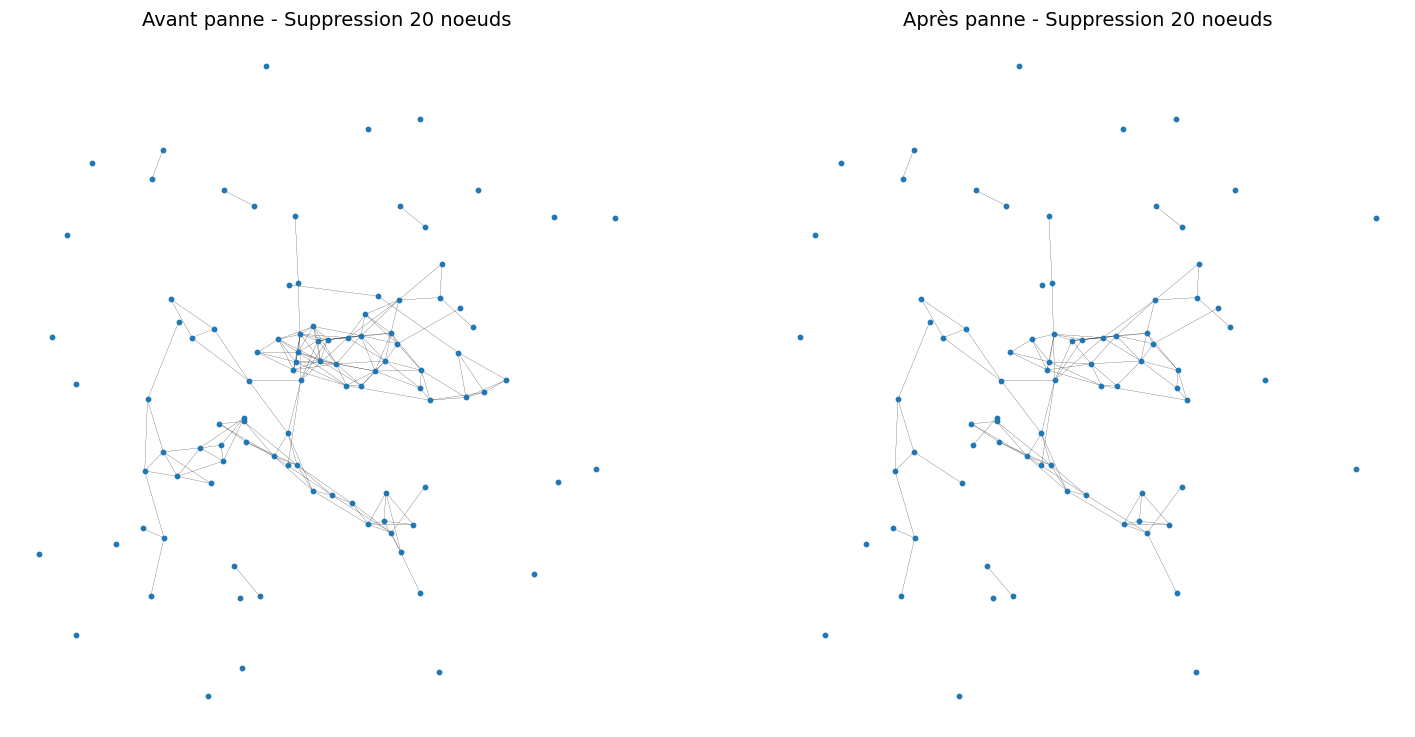

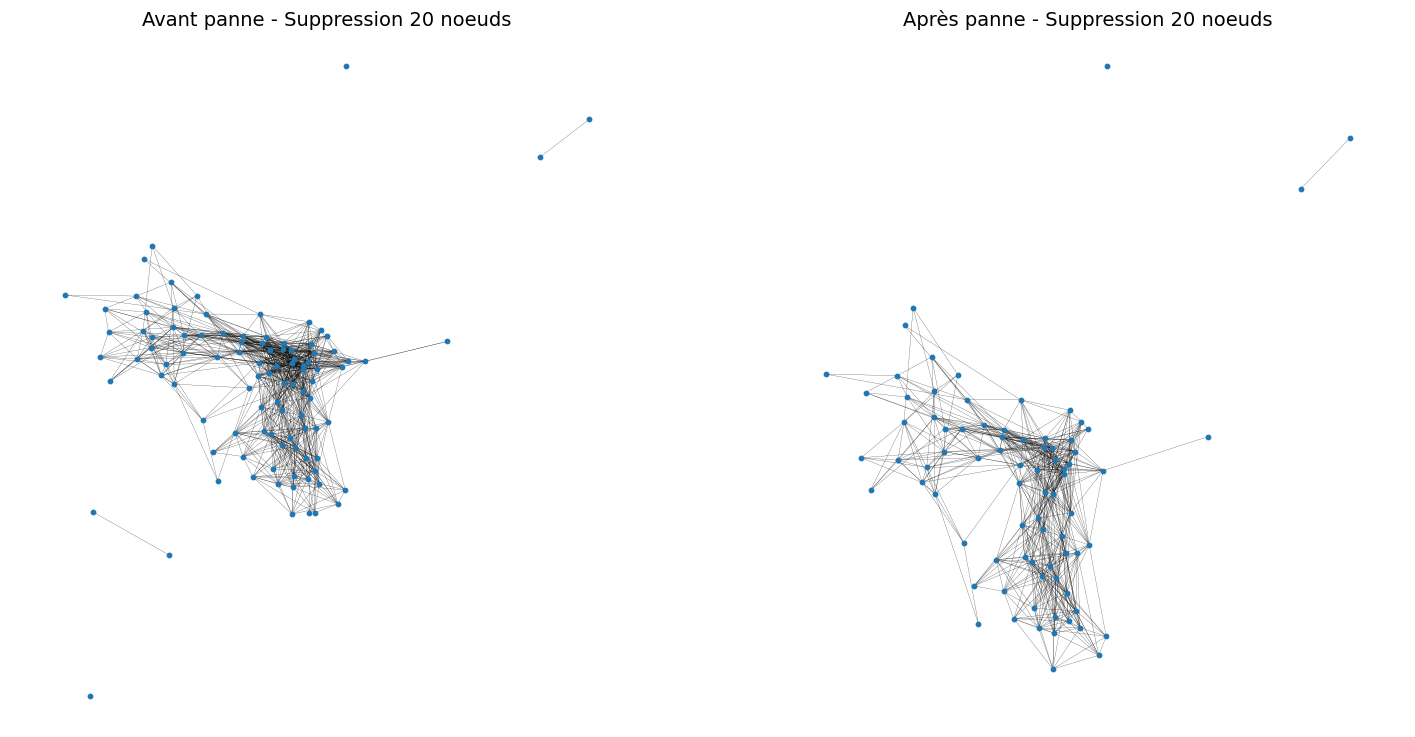

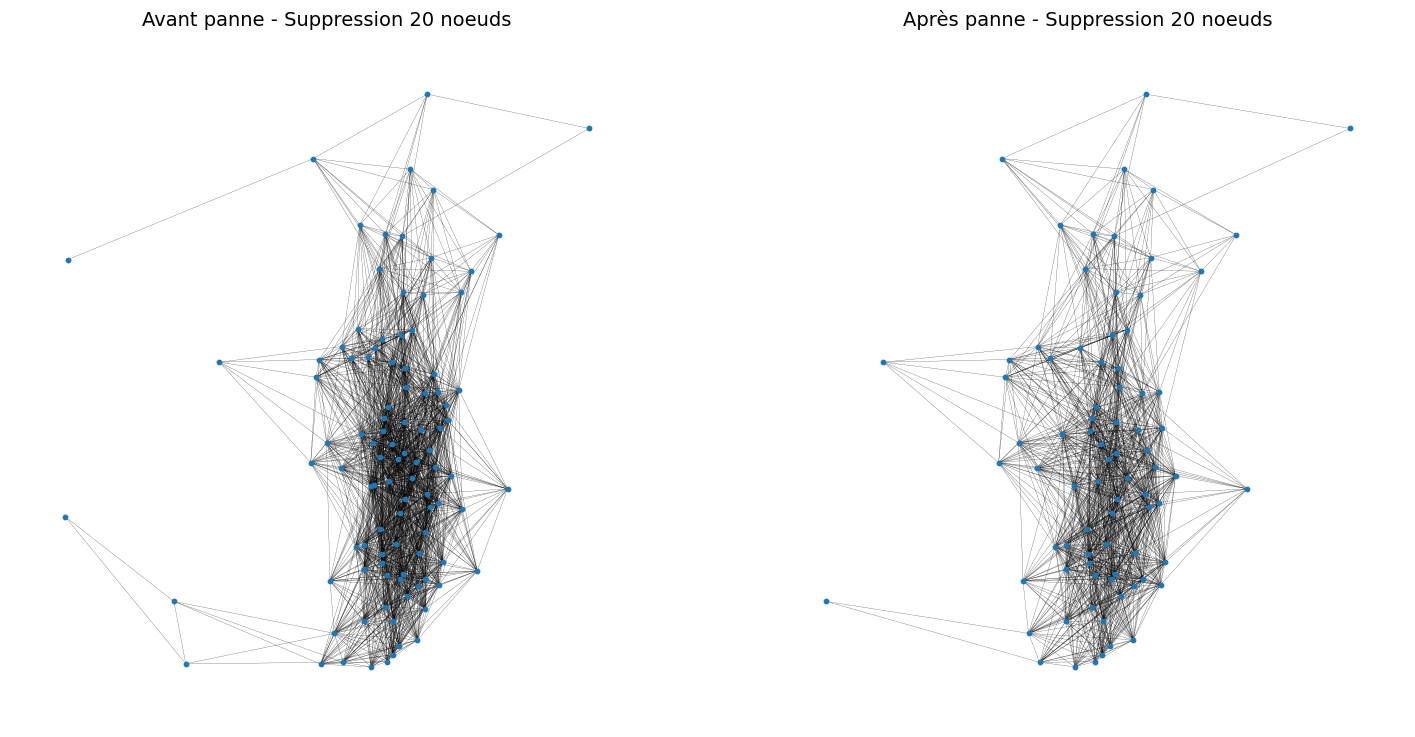

In [9]:
df1 = analyse_graph_on_graphobj_df(graph1, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)
df2 = analyse_graph_on_graphobj_df(graph2, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)
df3 = analyse_graph_on_graphobj_df(graph3, nb_to_remove=20, seed=42, targeted=False, centrality=False, display=True)


# Résilience ciblées

## Analyse de l'impact de la suppression des noeuds de plus haut degré

In [ ]:
def list_nodes_high_degree(graph, n):
    """
    Retourne une liste des nœuds avec le plus haut degré dans le graphe donné.

    Paramètres :
        - graph : le graphe à analyser
        - n : nombre de nœuds à retourner

    Retour :
        - Liste des nœuds avec le plus haut degré
    """
    degrees = dict(graph.degree)
    return sorted(degrees, key=degrees.get, reverse=True)[:n]

In [10]:
nb_de_noeuds = 20
nodes1 = list_nodes_high_degree(graph1, nb_de_noeuds)
nodes2 = list_nodes_high_degree(graph2, nb_de_noeuds)
nodes3 = list_nodes_high_degree(graph3, nb_de_noeuds)
graph1_minus_high_degree = delete_nodes(graph1.copy(), nodes1)
graph2_minus_high_degree = delete_nodes(graph2.copy(), nodes2)
graph3_minus_high_degree = delete_nodes(graph3.copy(), nodes3)

In [11]:
comparaison_graphs(graph1_minus_high_degree, graph2_minus_high_degree, graph3_minus_high_degree)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,69,100,80,3.48,1.725,False,False
1,Graphe <40km,883,415,100,80,17.66,10.375,False,False
2,Graphe <60km,1958,949,100,80,39.16,23.725,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,39,0.345716,0.224167,3.607920,1.443137,"(0.8615447679255358,)",0.967068,"[6, 7, 22, 39, 68, 70]",[]
1,Graphe <40km,6,7,0.633008,0.595230,29.926824,10.421014,"(1.6755923707745828,)",1.382958,"[22, 97]","[5, 40, 41, 50, 58, 63, 67, 87, 90]"
2,Graphe <60km,1,2,0.750514,0.731996,43.953131,19.117089,"(1.8480840346015286,)",1.761269,[],"[9, 19, 24, 55]"


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,2.147152,7,7


## Analyse de l'impact de la suppression des noeuds en fonction de leur centralité
1. centralité d'interdépendance

In [12]:
# calcul les meilleurs et pire noeuds centraux : 
n = 20  # nombre de nœuds à supprimer

betweenness_centrality_1 = nx.centrality.betweenness_centrality(graph1)
betweenness_centrality_2 = nx.centrality.betweenness_centrality(graph2)
betweenness_centrality_3 = nx.centrality.betweenness_centrality(graph3)

# Trier les nœuds par betweenness centrality
top_20_betweenness_1 = sorted(betweenness_centrality_1, key=betweenness_centrality_1.get, reverse=True)[:n]
bottom_20_betweenness_1 = sorted(betweenness_centrality_1, key=betweenness_centrality_1.get)[:n]

top_20_betweenness_2 = sorted(betweenness_centrality_2, key=betweenness_centrality_2.get, reverse=True)[:n]
bottom_20_betweenness_2 = sorted(betweenness_centrality_2, key=betweenness_centrality_2.get)[:n]

top_20_betweenness_3 = sorted(betweenness_centrality_3, key=betweenness_centrality_3.get, reverse=True)[:n]
bottom_20_betweenness_3 = sorted(betweenness_centrality_3, key=betweenness_centrality_3.get)[:n]

# Effectue la suppression et donc créer les nouveaux noeuds
graph1_betweenness_top = delete_nodes(graph1.copy(), top_20_betweenness_1)
graph1_betweenness_bottom = delete_nodes(graph1.copy(), bottom_20_betweenness_1)

graph2_betweenness_top = delete_nodes(graph2.copy(), top_20_betweenness_2)
graph2_betweenness_bottom = delete_nodes(graph2.copy(), bottom_20_betweenness_2)

graph3_betweenness_top = delete_nodes(graph3.copy(), top_20_betweenness_3)
graph3_betweenness_bottom = delete_nodes(graph3.copy(), bottom_20_betweenness_3)

In [13]:
# Comparaison des graphes en retirant les noeuds les plus centraux
comparaison_graphs(graph1_betweenness_top, graph2_betweenness_top, graph3_betweenness_top)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,81,100,80,3.48,2.025,False,False
1,Graphe <40km,883,425,100,80,17.66,10.625,False,False
2,Graphe <60km,1958,1137,100,80,39.16,28.425,True,False


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,40,0.345716,0.255645,3.607920,1.685083,"(0.8615447679255358,)",1.522828,"[6, 7, 22, 39, 68, 70]",[]
1,Graphe <40km,6,8,0.633008,0.584560,29.926824,12.681835,"(1.6755923707745828,)",1.388830,"[22, 97]","[6, 9, 11, 13, 19, 21, 24, 27, 44, 55, 63, 67,..."
2,Graphe <60km,1,3,0.750514,0.730203,43.953131,26.759169,"(1.8480840346015286,)",1.756590,[],[69]


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,∞,7,∞


In [14]:
# Comparaison des graphes en retirant les noeuds les moins centraux
comparaison_graphs(graph1_betweenness_bottom, graph2_betweenness_bottom, graph3_betweenness_bottom)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,160,100,80,3.48,4.000,False,False
1,Graphe <40km,883,802,100,80,17.66,20.050,False,True
2,Graphe <60km,1958,1599,100,80,39.16,39.975,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,23,0.345716,0.407265,3.607920,3.281205,"(0.8615447679255358,)",0.937625,"[6, 7, 22, 39, 68, 70]","[6, 7, 22, 33, 39, 68, 70]"
1,Graphe <40km,6,2,0.633008,0.675470,29.926824,27.926899,"(1.6755923707745828,)",1.757774,"[22, 97]","[22, 80, 97]"
2,Graphe <60km,1,1,0.750514,0.792590,43.953131,33.037975,"(1.8480840346015286,)",1.936006,[],[]


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,1.629114,7,5


On remarque que l'impact d'une panne sur les noeuds peu centraux a peu d'effets négatifs sur le réseau (on supprime les noeuds les plus difficiles d'accès, cela améliore donc même les statistiques des graphes). Nous allons nous intéresser par la suite seulement aux noeuds les plus centraux pour voir les effets les plus impactants.

2. Centralité de proximité

In [15]:
# Étape 1 : Calculer la centralité de proximité
closeness_centrality_1 = nx.closeness_centrality(graph1)
closeness_centrality_2 = nx.closeness_centrality(graph2)
closeness_centrality_3 = nx.closeness_centrality(graph3)

# Étape 2 : Récupérer les n nœuds les plus centraux
def top_n_nodes_by_centrality(centrality_dict, n):
    """Retourne les n premiers nœuds les plus centraux."""
    return sorted(centrality_dict, key=centrality_dict.get, reverse=True)[:n]

n = 20  # nombre de nœuds à supprimer
nodes1_closeness = top_n_nodes_by_centrality(closeness_centrality_1, n)
nodes2_closeness = top_n_nodes_by_centrality(closeness_centrality_2, n)
nodes3_closeness = top_n_nodes_by_centrality(closeness_centrality_3, n)

# Étape 3 : Supprimer les nœuds
graph1_closeness = delete_nodes(graph1.copy(), nodes1_closeness)
graph2_closeness = delete_nodes(graph2.copy(), nodes2_closeness)
graph3_closeness = delete_nodes(graph3.copy(), nodes3_closeness)

In [16]:
comparaison_graphs(graph1_closeness, graph2_closeness, graph3_closeness)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,77,100,80,3.48,1.925,False,False
1,Graphe <40km,883,435,100,80,17.66,10.875,False,False
2,Graphe <60km,1958,952,100,80,39.16,23.800,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,40,0.345716,0.299583,3.607920,1.547325,"(0.8615447679255358,)",1.226720,"[6, 7, 22, 39, 68, 70]",[]
1,Graphe <40km,6,7,0.633008,0.612534,29.926824,7.179800,"(1.6755923707745828,)",1.340219,"[22, 97]","[22, 41, 50, 55, 58, 63, 67, 87]"
2,Graphe <60km,1,2,0.750514,0.740441,43.953131,16.791772,"(1.8480840346015286,)",1.735323,[],"[9, 22, 41, 55, 67]"


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,2.160759,7,7


3. Centralité d'eigenvector

In [17]:
eigenvector_centrality_1 = nx.centrality.eigenvector_centrality(graph1)
eigenvector_centrality_2 = nx.centrality.eigenvector_centrality(graph2)
eigenvector_centrality_3 = nx.centrality.eigenvector_centrality(graph3)

# on enlève les 20 noeuds les plus centraux
n = 20
graph1_eigenvector = delete_nodes(graph1.copy(), list(eigenvector_centrality_1.keys())[0:n])
graph2_eigenvector = delete_nodes(graph2.copy(), list(eigenvector_centrality_2.keys())[0:n])
graph3_eigenvector = delete_nodes(graph3.copy(), list(eigenvector_centrality_3.keys())[0:n])

In [18]:
comparaison_graphs(graph1_eigenvector, graph2_eigenvector, graph3_eigenvector)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,112,100,80,3.48,2.800,False,False
1,Graphe <40km,883,559,100,80,17.66,13.975,False,False
2,Graphe <60km,1958,1215,100,80,39.16,30.375,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,30,0.345716,0.333095,3.607920,2.020725,"(0.8615447679255358,)",1.026584,"[6, 7, 22, 39, 68, 70]",[97]
1,Graphe <40km,6,6,0.633008,0.637194,29.926824,23.301873,"(1.6755923707745828,)",1.601662,"[22, 97]","[22, 41, 75, 97]"
2,Graphe <60km,1,1,0.750514,0.719991,43.953131,27.732278,"(1.8480840346015286,)",1.809789,[],[]


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,1.939557,7,7


4. Degré de centralité

In [19]:
def list_nodes_high_degree_centrality(graph, n):
    """
    Retourne une liste des nœuds avec le plus haut degré de centralité dans le graphe donné.

    Paramètres :
        - graph : le graphe à analyser
        - n : nombre de nœuds à retourner

    Retour :
        - Liste des nœuds avec le plus haut degré de centralité
    """
    centrality = nx.degree_centrality(graph)
    return sorted(centrality, key=centrality.get, reverse=True)[:n]



In [20]:
nb_de_noeuds = 20
nodes1 = list_nodes_high_degree_centrality(graph1, nb_de_noeuds)
nodes2 = list_nodes_high_degree_centrality(graph2, nb_de_noeuds)
nodes3 = list_nodes_high_degree_centrality(graph3, nb_de_noeuds)
graph1_minus_high_degree = delete_nodes(graph1.copy(), nodes1)
graph2_minus_high_degree = delete_nodes(graph2.copy(), nodes2)
graph3_minus_high_degree = delete_nodes(graph3.copy(), nodes3)

In [21]:
comparaison_graphs(graph1_minus_high_degree, graph2_minus_high_degree, graph3_minus_high_degree)

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression,Graphe connecté ?,Graphe connecté après ?
0,Graphe <20km,174,69,100,80,3.48,1.725,False,False
1,Graphe <40km,883,415,100,80,17.66,10.375,False,False
2,Graphe <60km,1958,949,100,80,39.16,23.725,True,True


,Nom,Nombre de communautés,Nombre de communautés après,Coefficient de clustering,Coefficient de clustering après,Redondance,Redondance après,Disparité,Disparité après,Criticité,Criticité après
0,Graphe <20km,36,39,0.345716,0.224167,3.607920,1.443137,"(0.8615447679255358,)",0.967068,"[6, 7, 22, 39, 68, 70]",[]
1,Graphe <40km,6,7,0.633008,0.595230,29.926824,10.421014,"(1.6755923707745828,)",1.382958,"[22, 97]","[5, 40, 41, 50, 58, 63, 67, 87, 90]"
2,Graphe <60km,1,2,0.750514,0.731996,43.953131,19.117089,"(1.8480840346015286,)",1.761269,[],"[9, 19, 24, 55]"


,Nom,Moyenne des plus courts chemins,Moyenne des plus courts chemins après,Diamètre,Diamètre après
0,Graphe <60km,1.88101,2.147152,7,7
